<a href="https://colab.research.google.com/github/manunarayanan/hello-world/blob/master/Practical2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on six
datasets. As part of the practical you should briefly read the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier

You should implement a Naïve Bayes Classifier directly in python. To keep your code tidy,
we recommend implementing it as a class. Make sure that your classifier can handle binary, continuous and categorical features, and an arbitrary number of class labels. Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical, and that there are
4 classes. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'], num_classes=4)

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The fit function is expected to estimate all the parameters ($\theta$ and $\pi$) of the NBC. The predict function is expected to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here we import the libraries. 

In [ ]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

Before implementing NBC, we suggest you first implement the three types of the distributions of the parameters of NBC. Your implementation should have two functions: **estimate** and **get_probability**. The estimate function takes some data as input and computes the maximum likelihood estimators (MLE) for the parameters $\theta$ of the distribution $p(x | \theta)$. The get_probability function takes a new input value $x_{new}$ and returns $p(x_{new} | \theta)$. For example, in the case of continuous features, we can use the Gaussian distribution. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data, and the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$. 

![alt text](pics/mle_4.png)


You can import statistic libraries for the implementation of the distributions. We recommend using the statistical functions provided by `scipy.stats`. Read the documentation here: https://docs.scipy.org/doc/scipy/reference/stats.html


In [ ]:
# Distribution for continuous features
class ContFeatureParam:
    # Calculate the Gaussian probability distribution function for x
    def __init__(self):
        pass

    def fit(self, X, y):
        sep_cont = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)]
        self.model = np.array([np.c_[np.mean(i, axis=0), np.std(i, axis=0)] for i in sep_cont])
        return self

    def _prob(self, x, mean, std):
        expt_cont = np.exp(- ((x - mean)**2 / (2 * std**2)))
        return np.log(expt_cont / (np.sqrt(2 * np.pi) * std))  

    def get_probability(self, X):
      # returns the density value of the input value val
      # Note the input value val could be a vector rather than a single value
        return [[sum(self._prob(i, *s) for s, i in zip(summaries, x))
                for summaries in self.model] for x in X]

    def estimate(self, X):
        # Estimate the parameters for the Gaussian distribution
        return np.argmax(self.get_probability(X), axis=1)


# Distribution for binary features
class BinFeatureParam:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        count_sample = X.shape[0]
        sep_x = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)]
        self.class_log_prior_ = [np.log(len(i) / count_sample) for i in sep_x]
        count = np.array([np.array(i).sum(axis=0) for i in sep_x]) + self.alpha

        smooth = 2 * self.alpha
        smoothed_x = np.array([len(i) + smooth for i in sep_x])
        self.feature_prob_ = count / smoothed_x[np.newaxis].T
        return self

    def get_probability(self, X):
        return [(np.log(self.feature_prob_) * x + \
                 np.log(1 - self.feature_prob_) * np.abs(x - 1)
                ).sum(axis=1) + self.class_log_prior_ for x in X]             

    def estimate(self, X):
        #  Estimate the parameters for the Bernoulli distribution
        return np.argmax(self.get_probability(X), axis=1)
        

# # Distribution for categorical features
class CatFeatureParam:
      def __init__(self, alpha=1.0):
          self.alpha = alpha

      def fit(self, X, y):
          cnt = X.shape[0]
          #sep_category = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)]
          #sep_category = [[x for x in X if x[-1] == c] for c in np.unique(y)]
          newX = X.copy(deep = True)
          newX[y.name] = y.loc[:]
          sep_category = []
          y_unique = y.unique()
          for c in y_unique:
              sep_category.append(newX[newX[y.name] == c])
              sep_category[-1].drop(y.name, axis=1, inplace=True)
          self.class_log_prior_ = [np.log(len(i) / cnt) for i in sep_category]
          count_category = np.array([np.array(i).sum(axis=0) for i in sep_category]) + self.alpha
          self.feature_log_prob_ = np.log(count_category.astype(float) / count_category.astype(float).sum(axis=1)[np.newaxis].T)
          return self

      def get_probability(self, X):
          #return [np.multiply(self.feature_log_prob_, x).sum(axis=1) + self.class_log_prior_ for x in X]
          res_prob = []
          for idx in range(len(X)):
              res_prob.append(np.multiply(self.feature_log_prob_, X.iloc[idx].values).sum(axis=1) + self.class_log_prior_)
          return res_prob

      def estimate(self, X):
          # Estimate the parameters for the Multinoulli distribution
          return np.argmax(self.get_probability(X), axis=1)

        

Let us now implement a class for NBC. We'll keep it simple and try to follow the sklearn models. We'll have an init function, fit function and predict function.

**Hints for function fit**: Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$. 
The fit function will estimate the parameters for NBC based on the training data. 
Here we give you some hints how to estimate the $\theta$ in $p(\mathbf{x} \mid y, \theta)$. 

For each class $c$, we want to estimate the $\theta_c$ for the distribution $p(\mathbf{x} \mid y = c, \theta_c)$. 
Since the assumption of NBC that the features are conditionally independent given the class $c$, the class conditional distribution is a product of $D$ distributions, one for each feature: $p(\mathbf{x} \mid y = c, \theta_c) = \prod_{j}^{D} p(x_j \mid y = c, \theta_{jc})$. Hence, we need to estimate the $\theta_{jc}$ based on the data with class $c$ and feature $j$. 

![alt text](pics/fit_4.png)


**Hints for function predict**: The predict function should compute the probabilities $p(y = c \mid \mathbf{x}_{new}, \pi, \theta)$ for the new inputs $\mathbf{x}_{new}$ on all classes by applying the Bayes rule:

$$p(y = c \mid \mathbf{x}_{new}, \pi, \theta) = \frac{p(y = c \mid \pi_c) \cdot p(\mathbf{x}_{new} \mid y=c, \theta)}{\sum^{C}_{c'=1}p(y=c' \mid \pi_{c'}) \cdot p(\mathbf{x}_{new} \mid y=c', \theta_{c'})},$$

and then return the class that has the largest probability:

$$y_{predict} = \underset{c}{arg\,\max} \, {p(y = c \mid \mathbf{x}_{new}, \theta_c)}.$$

Here we give you some hints on the computation of $p(\mathbf{x}_{new} \mid y=c, \theta_c)$. 
Due to the conditional independence assumption, we have $p(\mathbf{x}_{new} \mid y=c, \theta_c) = \prod_{j}^{D} p(x^j_{new} \mid y = c, \theta_{jc})$. Since we have got the parameters $\theta_{jc}$ in the fit phase,  we can use them to compute the probabilities for the new data. 

![alt text](pics/predict_3.png)

In [ ]:
class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['r', 'r', 'r', 'r']
    #   num_classes: number of classes of labels
    def __init__(self, feature_types=[], num_classes=0):
        self.feature_types = feature_types
        self.num_classes = num_classes
    
    # The function uses the input data to estimate all the parameters of the NBC
    # You should use the parameters based on the types of the features
    def fit(self, X, y):
        if len(set(self.feature_types)) == 1 and 'r' in set(self.feature_types):
           contNB = ContFeatureParam().fit(X, y)
           self.NB = contNB
           return contNB
        elif len(set(self.feature_types)) == 1 and 'b' in set(self.feature_types):
            binNB = BinFeatureParam(alpha=1).fit(np.where(X > 0, 1, 0), y)
            self.NB = binNB
            return binNB
        elif len(set(self.feature_types)) == 1 and 'c' in set(self.feature_types):
            catNB = CatFeatureParam(alpha=1).fit(X,y)
            self.NB = catNB
            return catNB
                
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        if 'b' in set(self.feature_types):
            y_predicted = np.where(self.NB.estimate(np.where(X > 0, 1, 0)) == 1, 'republican', 'democrat')
        elif 'r' in set(self.feature_types):
            y_predicted = self.NB.estimate(X)
        elif 'c' in set(self.feature_types):
            y_predicted = self.NB.estimate(X)
        return y_predicted

**Implementation Issues**
- Fell free to add auxiliary functions. 
- Don't forget to compute $p(y=c | \pi)$ 
- Remember to do all the calculations in log space to avoid running into underflow issues. Read more: (Mur) Chapter 3.5.3
- Your implementation should be able to handle missing values
- As far as possible use matrix operations. So assume that Xtrain, ytrain, Xtest will all
be numpy arrays. Try and minimise your use of python loops. (In general, looping over
classes or features is OK, but looping over data is probably not a good idea.)
- The variance parameter for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6.
Note that this is essential to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. Also, you want to ensure that the estimates for the parameter for the Bernoulli or Multinoulli random variables
is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).


You can use the below code to do sanity check of your implementation using the iris dataset. All features of the iris dataset are continuous, so you do not need to implement all types of feature parameters to check your code. 

You should expect your implementation has an accuracy larger than 90%. 

## Logistic Regression

For logistic regression, you should use the implementation in sklearn. Adding the following
line will import the LR model.

    from sklearn.linear_model import LogisticRegression

Read the information provided on the following links to understand some details about how the
logistic regression model is implemented in scikit-learn.
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

You will compare the classification error of the NBC and LR trained on increasingly
larger training datasets. Because the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a
function of the size of the training data. Plot these curves for NBC and LR on the datasets.

In [ ]:
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers

#train classifiers with 10%, 20%, ..., 100% of the training data
splits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8 , 0.9, 1]

def compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10):
    tst_errs_nbc =[]
    tst_errs_lr = []
    for split in splits:
        Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=split, random_state=1)

        NB = nbc.fit(Xtrain, ytrain)
        lr.fit(Xtrain, ytrain)

        if 'b' in set(nbc.feature_types):
          y_nb_predicted = np.where(NB.estimate(np.where(Xtest > 0, 1, 0)) == 1, 'republican', 'democrat')
        elif 'r' in set(nbc.feature_types):
          y_nb_predicted = NB.estimate(Xtest)
        elif 'c' in set(nbc.feature_types):
          y_nb_predicted = NB.estimate(Xtest)

        tst_errs_nbc.append(1-accuracy_score(ytest,y_nb_predicted))
        tst_errs_lr.append(1-lr.score(Xtest,ytest))

    return tst_errs_nbc, tst_errs_lr

The utility function below defines the function for plotting. 

In [ ]:
def makePlot(nbc_perf, lr_perf, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * 10 for i in range(10)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. prepare the data for the two classifiers
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

In [ ]:
#sanity check code
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
shuffler = np.random.permutation(N)
Xtrain = X[shuffler[:Ntrain]]
ytrain = y[shuffler[:Ntrain]]
Xtest = X[shuffler[Ntrain:]]
ytest = y[shuffler[Ntrain:]]


nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy)

Accuracy: 0.9333333333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Iris Classification Error List:  [0.0, 0.033333333333333326, 0.0444444444444444, 0.050000000000000044, 0.040000000000000036, 0.0444444444444444, 0.03809523809523807, 0.06666666666666665, 0.051851851851851816, 0.0] [0.06666666666666665, 0.1333333333333333, 0.1333333333333333, 0.09999999999999998, 0.07999999999999996, 0.06666666666666665, 0.06666666666666665, 0.09166666666666667, 0.10370370370370374, 0.0]


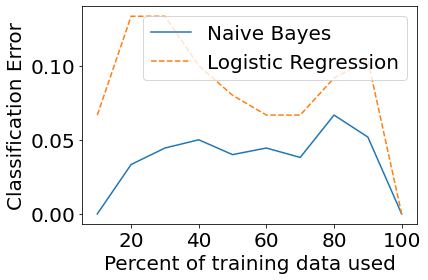

In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

iris = load_iris()
X, y = iris['data'], iris['target']

# Naive Bayes Classifier
nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)

# Logistic Regression
contLR = LogisticRegression(random_state=0, solver="lbfgs", multi_class="ovr")

# Compare NB and LR Results
tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc_iris, contLR, X, y, num_runs=200, num_splits=10)
print("Iris Classification Error List: ",tst_errs_nbc, tst_errs_lr) 

makePlot(tst_errs_nbc, tst_errs_lr, title=None)

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records


Vote Classification Error List:  [0.08333333333333337, 0.12765957446808507, 0.08571428571428574, 0.07526881720430112, 0.08620689655172409, 0.1071428571428571, 0.09815950920245398, 0.10215053763440862, 0.10526315789473684, 0.0] [0.0, 0.04255319148936165, 0.02857142857142858, 0.032258064516129004, 0.03448275862068961, 0.05714285714285716, 0.06134969325153372, 0.06451612903225812, 0.09569377990430628, 0.0]


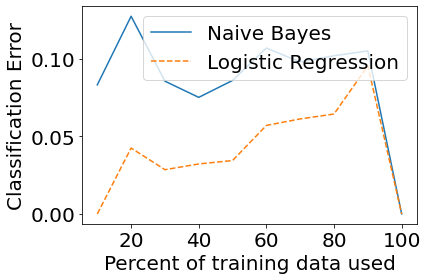

In [ ]:
import pandas as pd
import numpy as np

voting = pd.read_csv('/content/drive/MyDrive/Data Science/voting.csv')

# remove nan or replace
voting = voting.dropna()
 
# convert y/n to numeric 1/0
mapping = { "y": 1, "n" : 0}
votingX = voting.iloc[:,1:17].replace(mapping)
votingY = voting["label"]

# Naive Bayes Classifier
nbc_vote = NBC(feature_types=['b', 'b', 'b', 'b','b', 'b', 'b', 'b','b', 'b', 'b', 'b','b', 'b', 'b', 'b'], num_classes=2)

# Logistic Regression
contVote = LogisticRegression()

# Compare NB and LR Results
tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc_vote, contVote, votingX,votingY, num_runs=200, num_splits=10)
print("Vote Classification Error List: ",tst_errs_nbc, tst_errs_lr) 

makePlot(tst_errs_nbc, tst_errs_lr, title=None)

**Dataset 3: Car Evaluation Dataset**

https://archive.ics.uci.edu/ml/datasets/car+evaluation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   buying         1728 non-null   object
 1   maint          1728 non-null   object
 2   doors          1728 non-null   object
 3   persons        1728 non-null   object
 4   lug_boot       1728 non-null   object
 5   safety         1728 non-null   object
 6   acceptability  1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.p

Car Classification Error List:  [0.8439306358381503, 0.24855491329479773, 0.7938342967244701, 0.7875722543352601, 0.7800925925925926, 0.7830279652844745, 0.7859504132231405, 0.7736804049168474, 0.9601542416452442, 1.0] [0.2601156069364162, 0.2832369942196532, 0.3102119460500964, 0.30202312138728327, 0.3090277777777778, 0.32015429122468664, 0.3090909090909091, 0.3239334779464931, 0.3316195372750642, 0.0]


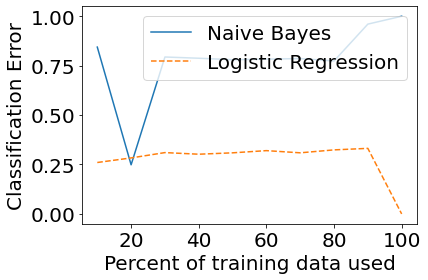

In [ ]:
car = pd.read_csv('/content/drive/MyDrive/Data Science/car.csv')
car.info()

# No 'nan' to remove or replace
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

label_encoder = LabelEncoder()
feature_encoder = OrdinalEncoder()
features = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']
car[features] = feature_encoder.fit_transform(car[features])
car['acceptability'] = label_encoder.fit_transform(car['acceptability'])

carX = car.drop('acceptability',axis=1)
carY = car["acceptability"]

# Naive Bayes Classifier
nbc_car = NBC(feature_types=['c', 'c', 'c', 'c', 'c', 'c'], num_classes=4)

# Logistic Regression
contcar = LogisticRegression()

# Compare NB and LR Results
tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc_car, contcar, carX, carY, num_runs=200, num_splits=10)
print("Car Classification Error List: ",tst_errs_nbc, tst_errs_lr) 

makePlot(tst_errs_nbc, tst_errs_lr, title=None)

**Dataset 4: Breast Cancer Dataset**

https://archive.ics.uci.edu/ml/datasets/breast+cancer

In [ ]:
cancer = pd.read_csv('/content/drive/MyDrive/Data Science/breast-cancer.csv')

cancer = cancer.replace('?',np.nan)
cancer = cancer.dropna()

print('Categories - age')
print(cancer['age'].value_counts())
print('\n')
print('Categories - menopause')
print(cancer['menopause'].value_counts())
print('\n')
print('Categories - tumor-size')
print(cancer['tumor-size'].value_counts())
print('\n')
print('Categories - inv-nodes')
print(cancer['inv-nodes'].value_counts())
print('\n')
print('Categories - node-caps')
print(cancer['node-caps'].value_counts())
print('\n')
print('Categories - deg-malig')
print(cancer['deg-malig'].value_counts())
print('\n')
print('Categories - breast')
print(cancer['breast'].value_counts())
print('\n')
print('Categories - breast-quad')
print(cancer['breast-quad'].value_counts())
print('\n')
print('Categories - irradiat')
print(cancer['irradiat'].value_counts())
print('\n')
print('Categories - Class')
print(cancer['Class'].value_counts())
print('\n')

Categories - age
50-59    91
40-49    89
60-69    55
30-39    36
70-79     5
20-29     1
Name: age, dtype: int64


Categories - menopause
premeno    149
ge40       123
lt40         5
Name: menopause, dtype: int64


Categories - tumor-size
30-34    57
25-29    51
20-24    48
15-19    29
10-14    28
40-44    22
35-39    19
50-54     8
0-4       8
5-9       4
45-49     3
Name: tumor-size, dtype: int64


Categories - inv-nodes
0-2      209
3-5       34
6-8       17
9-11       7
15-17      6
12-14      3
24-26      1
Name: inv-nodes, dtype: int64


Categories - node-caps
no     221
yes     56
Name: node-caps, dtype: int64


Categories - deg-malig
2    129
3     82
1     66
Name: deg-malig, dtype: int64


Categories - breast
left     145
right    132
Name: breast, dtype: int64


Categories - breast-quad
left_low     106
left_up       94
right_up      33
right_low     23
central       21
Name: breast-quad, dtype: int64


Categories - irradiat
no     215
yes     62
Name: irradiat, dtype: int64

In [ ]:
#change categories to numbers
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder

label_encoder = LabelEncoder()

cancer['age'] = label_encoder.fit_transform(cancer['age'])
cancer['tumor-size'] = label_encoder.fit_transform(cancer['tumor-size'])
cancer['inv-nodes'] = label_encoder.fit_transform(cancer['inv-nodes'])
cancer['irradiat'] = label_encoder.fit_transform(cancer['irradiat'])

label_binarizer = LabelBinarizer()
cancer['node-caps'] = label_binarizer.fit_transform(cancer['node-caps'].astype(str))
cancer['breast'] = label_binarizer.fit_transform(cancer['breast'])
cancer['Class'] = label_binarizer.fit_transform(cancer['Class'])

one_hot_encoder = OneHotEncoder()
onehot_menopause = one_hot_encoder.fit_transform(cancer[['menopause']]).toarray()
onehot_breastquad = one_hot_encoder.fit_transform(cancer[['breast-quad']]).toarray()
cancer['menopause'] = onehot_menopause.tolist()
cancer['breast-quad'] = onehot_breastquad.tolist()

In [ ]:
cancerX = cancer.drop('Class',axis=1)
cancerY = cancer["Class"]

# Naive Bayes Classifier
nbc_cancer = NBC(feature_types=['c', 'c', 'c', 'c', 'b', 'c', 'b', 'c', 'c'], num_classes=2)

# Logistic Regression
contcancer = LogisticRegression()

# Compare NB and LR Results
tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc_cancer, contcancer, cancerX, cancerY, num_runs=200, num_splits=10)
print("Cancer Classification Error List: ",tst_errs_nbc, tst_errs_lr) 

makePlot(tst_errs_nbc, tst_errs_lr, title=None)


X = cancer.iloc[:, 1:-1].values
y = cancer.Class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

nb = CatFeatureParam(alpha=1).fit(X_train, y_train)

ValueError: ignored

**Dataset 5: Ionosphere Dataset**

https://archive.ics.uci.edu/ml/datasets/ionosphere

In [ ]:
ionosphere = pd.read_csv('/content/drive/MyDrive/Data Science/ionosphere.csv')

#from sklearn.preprocessing import MinMaxScaler, StandardScaler
ionosphere = ionosphere.drop('feature2',axis=1)
ionosphere['label'] = label_encoder.fit_transform(ionosphere['label'])

ionosphereX = ionosphere.drop('label',axis=1)
ionosphereY = ionosphere["label"]

# Naive Bayes Classifier
nbc_ionosphere = NBC(feature_types=['b', ['r'] * 33], num_classes=2)

# Logistic Regression
contionosphere = LogisticRegression()

# Compare NB and LR Results
tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc_ionosphere, contionosphere, ionosphereX, ionosphereY, num_runs=200, num_splits=10)
print("Ionosphere Classification Error List: ",tst_errs_nbc, tst_errs_lr) 

makePlot(tst_errs_nbc, tst_errs_lr, title=None)

TypeError: ignored

**Dataset 6: Sonar Dataset**

http://archive.ics.uci.edu/ml/datasets/connectionist+bench+%28sonar,+mines+vs.+rocks%29

In [ ]:
sonar = pd.read_csv('/content/drive/MyDrive/Data Science/sonar.csv')

sonarX = sonar.drop('label',axis=1)
sonarY = sonar["label"]

Naive Bayes Classifier
nbc_sonar = NBC(feature_types=[['r'] * 60], num_classes=2)

# Logistic Regression
contsonar = LogisticRegression()

# Compare NB and LR Results
tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc_sonar, contsonar, sonarX, sonarY, num_runs=200, num_splits=10)
print("Sonar Classification Error List: ",tst_errs_nbc, tst_errs_lr) 

makePlot(tst_errs_nbc, tst_errs_lr, title=None)


SyntaxError: ignored